# Comparison with Empirical Bayes

Data are available here: https://github.com/Tchanders/network_inference_tutorials

In [7]:
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform

from regain.covariance import graph_lasso_
from regain.covariance import latent_graph_lasso_; reload(latent_graph_lasso_);
from regain import utils

In [2]:
from sklearn.metrics import average_precision_score
from __future__ import division
def structure_error(true, pred, thresholding=False, eps=1e-2, no_diagonal=False, top_n=None):
    # avoid inplace modifications
    true = true.copy()
    pred = pred.copy()

    y_true = squareform(true, checks=None)
    y_pred = squareform(pred, checks=None)

    average_precision = average_precision_score(y_true > 0, y_pred)

    if thresholding:
        pred[np.abs(pred) < eps] = 0
    tn_to_remove = 0
    
    if top_n is not None:
        m = np.min(sorted(np.abs(y_pred))[::-1][:int(y_pred.size * top_n)])
        pred[np.abs(pred) < m] = 0
    
    if no_diagonal:
        if true.ndim > 2:
            true = np.array([t - np.diag(np.diag(t)) for t in true])
            pred = np.array([t - np.diag(np.diag(t)) for t in pred])
            tn_to_remove = np.prod(true.shape[:2])
        else:
            true -= np.diag(np.diag(true))
            pred -= np.diag(np.diag(pred))
            tn_to_remove = true.shape[0]
    true[true != 0] = 1
    pred[pred != 0] = 2
    res = true + pred

    TN = np.count_nonzero((res == 0).astype(float))- tn_to_remove
    FN = np.count_nonzero((res == 1).astype(float))
    FP = np.count_nonzero((res == 2).astype(float))
    TP = np.count_nonzero((res == 3).astype(float))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN)
    miss_rate = FN / (TP + FN) or 1 - recall
    f1 = 2 * precision * recall / (precision + recall) \
        if precision + recall > 0 else 0

    accuracy = (TP + TN) / true.size
    prevalence = (TP + FN) / true.size

    fall_out = FP / (FP + TN) if (FP + TN) > 0 else 1
    specificity = TN / (FP + TN) if (FP + TN) > 0 else 1. - fall_out

    balanced_accuracy = 0.5 * (recall + specificity)
    false_discovery_rate = FP / (TP + FP) if TP + FP > 0 else 1 - precision
    false_omission_rate = FN / (FN + TN) if FN + TN > 0 else 0
    negative_predicted_value = TN / (FN + TN) if FN + TN > 0 else \
        1 - false_omission_rate

    positive_likelihood_ratio = recall / fall_out if fall_out > 0 else 0
    negative_likelihood_ratio = miss_rate / specificity \
        if specificity > 0 else 0
    diagnostic_odds_ratio = \
        positive_likelihood_ratio / negative_likelihood_ratio if \
        negative_likelihood_ratio > 0 else 0

    dictionary = dict(
        tp=TP, tn=TN, fp=FP, fn=FN, precision=precision, recall=recall,
        f1=f1, accuracy=accuracy, false_omission_rate=false_omission_rate,
        fdr=false_discovery_rate, npv=negative_predicted_value,
        prevalence=prevalence, miss_rate=miss_rate, fall_out=fall_out,
        specificity=specificity, plr=positive_likelihood_ratio,
        nlr=negative_likelihood_ratio, dor=diagnostic_odds_ratio,
        balanced_accuracy=balanced_accuracy,
        average_precision=average_precision)
    return dictionary

Compare the results with Julia library

In [3]:
from itertools import product

# n_genes = 50
# i = 3
# algorithm = 'mi'
# df = pd.read_csv("../simulated_datasets/{}_yeast{}_large.txt".format(n_genes, i), delimiter='\t', index_col=0).T

In [4]:
score = 'precision'
# score = 'average_precision'

In [13]:
results = {}
reload(utils)
path = "/home/fede/src/network_inference_tutorials"
for n_genes, i in product([50, 100], range(1,4)):
    true_network = utils.read_network(os.path.join(path, "goldstandards/{}_yeast{}.tsv".format(n_genes, i)))
    
    for algorithm, threshold in product(['mi','puc'], [0.2, 0.15, 0.1, 0.05]):
        df = utils.read_network(os.path.join(path, "networks/{}_yeast{}_large_{}.txt".format(n_genes, i, algorithm)),
                          threshold=threshold, delimiter='\t')
        results.setdefault(threshold, []).append(structure_error(true_network.values, df.values,
                                                                 no_diagonal=False)[score])

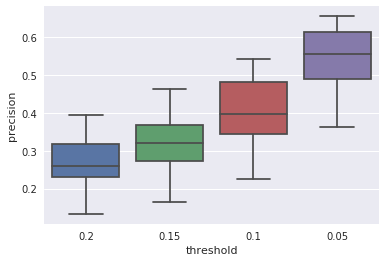

In [14]:
nn = pd.DataFrame(columns=['threshold', score])
for k, v in results.items():
    for x in v:
        nn = nn.append({'threshold': k, score:x}, ignore_index=True)

bb = nn.copy()

bb = bb.sort_values('threshold', ascending=False)
sns.boxplot(x='threshold', y=score, data=bb, order=bb.threshold.unique())

In [17]:
results_gl = {}
path = "/home/fede/src/network_inference_tutorials"

for n_genes, i in product([50, 100], range(1,4)):
    true_network = utils.read_network(os.path.join(path, "goldstandards/{}_yeast{}.tsv".format(n_genes, i)))
    filename = "simulated_datasets/{}_yeast{}_large.txt".format(n_genes, i) 
    df = pd.read_csv(os.path.join(path, filename), delimiter='\t', index_col=0).T 
    
    alphas = [1e-3] if n_genes == 50 else [0.001]
    for alpha in alphas:
        for threshold in [0.2, 0.15, 0.1, 0.05]:
            gl = graph_lasso_.GraphLasso(verbose=0, alpha=alpha,update_rho_options=dict(mu=5), tol=1e-6, rtol=1e-6,
                                                       max_iter=500).fit(df.values)
            results_gl.setdefault(threshold, []).append(structure_error(true_network.values, gl.precision_,
                                                                thresholding=True, eps=1e-4, top_n=threshold,
                                                                 no_diagonal=False)[score])

/home/fede/src/slipguru/regain/regain/covariance/graph_lasso_.py:133: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [18]:
nn = pd.DataFrame(columns=['threshold', score])
for k, v in results_gl.items():
    for x in v:
        nn = nn.append({'threshold': k, score:x}, ignore_index=True)

dd = nn.copy()
# bb['precision'] *= 2

dd = dd.sort_values('threshold', ascending=False)

In [19]:
reload(latent_graph_lasso_)
path = "/home/fede/src/network_inference_tutorials"
results_regain = {}

for n_genes, i in product([50, 100], range(1,4)):
    true_network = utils.read_network(os.path.join(path, "goldstandards/{}_yeast{}.tsv".format(n_genes, i)))
    filename = "simulated_datasets/{}_yeast{}_large.txt".format(n_genes, i)
    alphas = [1e-3] if n_genes == 50 else [0.001]
    taus = [2e-2] if n_genes == 50 else [1e-4]
    df = pd.read_csv(os.path.join(path, filename), delimiter='\t', index_col=0).T    

    for alpha, tau in product(alphas, taus):
        lgl = latent_graph_lasso_.LatentGraphLasso(
                verbose=0, alpha=alpha, tau=tau, update_rho_options=dict(mu=5), tol=1e-6, rtol=1e-6,
                max_iter=600).fit(df.values)

        for threshold in [0.2, 0.15, 0.1, 0.05]:
            ss = structure_error(true_network.values, lgl.precision_, 
                             thresholding=True, eps=1e-6, top_n=threshold,
                             no_diagonal=False)[score]
            results_regain.setdefault(threshold, []).append(ss)
        print(alpha, tau, ss)

/home/fede/src/slipguru/regain/regain/covariance/latent_graph_lasso_.py:131: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


(0.001, 0.02, 0.6744186046511628)
(0.001, 0.02, 0.686046511627907)
(0.001, 0.02, 0.7093023255813954)
(0.001, 0.0001, 0.32167832167832167)
(0.001, 0.0001, 0.4146341463414634)
(0.001, 0.0001, 0.3649122807017544)


In [20]:
nn = pd.DataFrame(columns=['threshold', score])
for k, v in results_regain.items():
    for x in v:
        nn = nn.append({'threshold': k, score:x}, ignore_index=True)

cc = nn.copy()
# bb['precision'] *= 2

cc = cc.sort_values('threshold', ascending=0)

An advantage in taking into account latent variables is visible in the following.

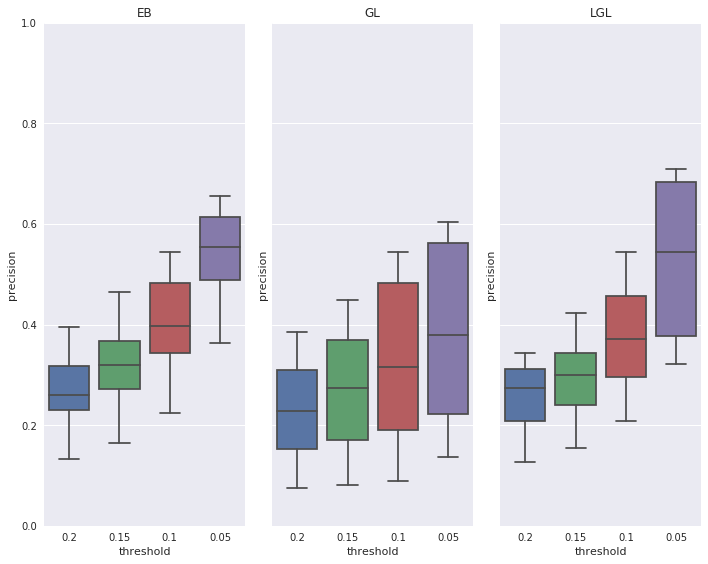

In [21]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(10,8))
sns.boxplot(x='threshold', y=score, data=bb, order=bb.threshold.unique(), ax=ax[0])
ax[0].set_title("EB")
sns.boxplot(x='threshold', y=score, data=dd, order=dd.threshold.unique(), ax=ax[1])
ax[1].set_title("GL")
sns.boxplot(x='threshold', y=score, data=cc, order=cc.threshold.unique(), ax=ax[2])
ax[2].set_title("LGL")

plt.ylim([0, 1]);
f.tight_layout()